<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-18.1" data-toc-modified-id="Figure-18.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 18.1</a></span></li><li><span><a href="#Figure-18.2" data-toc-modified-id="Figure-18.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 18.2</a></span></li><li><span><a href="#Figure-18.3" data-toc-modified-id="Figure-18.3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 18.3</a></span></li><li><span><a href="#Figure-18.4" data-toc-modified-id="Figure-18.4-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 18.4</a></span></li><li><span><a href="#Figure-18.5" data-toc-modified-id="Figure-18.5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 18.5</a></span></li><li><span><a href="#Figure-18.6" data-toc-modified-id="Figure-18.6-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 18.6</a></span></li><li><span><a href="#Figure-18.7" data-toc-modified-id="Figure-18.7-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Figure 18.7</a></span></li><li><span><a href="#Figure-18.8" data-toc-modified-id="Figure-18.8-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Figure 18.8</a></span></li><li><span><a href="#Figure-18.9" data-toc-modified-id="Figure-18.9-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Figure 18.9</a></span></li><li><span><a href="#Figure-18.10" data-toc-modified-id="Figure-18.10-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Figure 18.10</a></span></li><li><span><a href="#Figure-18.11" data-toc-modified-id="Figure-18.11-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Figure 18.11</a></span></li><li><span><a href="#Figure-18.12" data-toc-modified-id="Figure-18.12-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Figure 18.12</a></span></li><li><span><a href="#Figure-18.13" data-toc-modified-id="Figure-18.13-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Figure 18.13</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 18
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import signal as sig

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))
    
#chan2useidx = chan_labels.index('Pz')

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 18.1

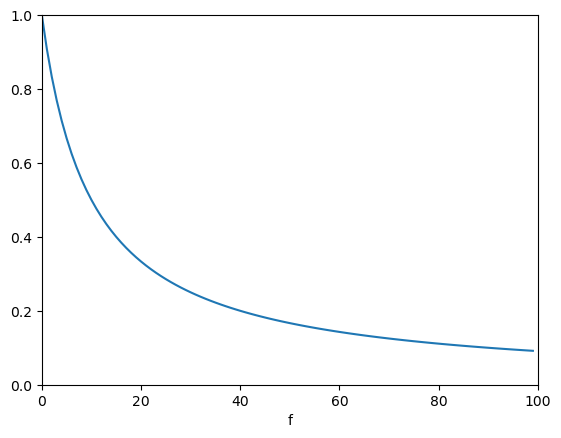

In [4]:
# 1/f function
plt.figure()
c = 1
x = 1

plt.plot(c/np.arange(1,11,.1)**x)
_=plt.setp(plt.gca(), 'xlim', [0,100], 'ylim', [0,1], 'xlabel', 'f')

## Figure 18.2

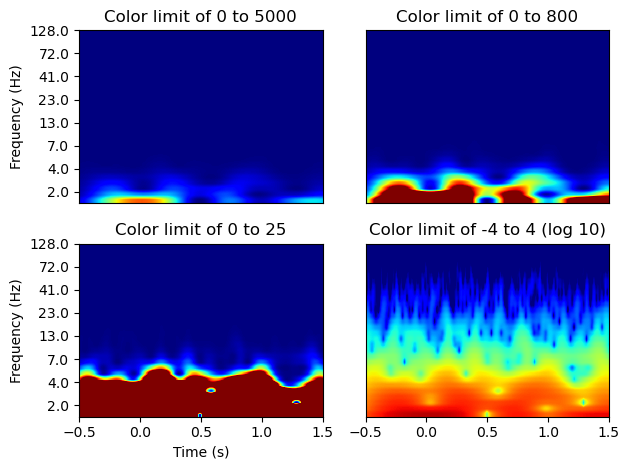

In [5]:
# wavelet parameters
min_freq = 2
max_freq = 128
num_frex = 30

# other wavelet parameters
frequencies = np.logspace(np.log10(min_freq),np.log10(max_freq),num_frex)
time = np.arange(-1,1+1/srate,1/srate)
half_of_wavelet_size = len(time)//2


# FFT parameters (use next-power-of-2)
n_wavelet     = len(time)
n_data        = pnts;
n_convolution = n_wavelet+n_data-1;
n_conv_pow2   = int(2**np.ceil(np.log2(n_convolution)))
wavelet_cycles= 4

#FFT of data (note: this doesn't change on frequency iteration)
fft_data = np.fft.fft(data[0, 22,:],n_conv_pow2)

#initialize output time-frequency data
tf_data = np.zeros([len(frequencies),pnts])


for fi in range(len(frequencies)):
    
    #create wavelet and get its FFT
    wavelet = (np.pi*frequencies[fi]*np.sqrt(np.pi))**(-.5) * np.exp(2*1j*np.pi*frequencies[fi]*time)* np.exp(-time**2/(2*( wavelet_cycles /(2*np.pi*frequencies[fi]))**2))/frequencies[fi]                                                                                                 
                                                                                                      
    fft_wavelet = np.fft.fft(wavelet,n_conv_pow2)
    
    #run convolution
    convolution_result_fft = np.fft.ifft(fft_wavelet * fft_data,n_conv_pow2)
    convolution_result_fft = convolution_result_fft[:n_convolution] # note: here we remove the extra points from the power-of-2 FFT
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
    
    #put power data into time-frequency matrix
    tf_data[fi,:] = np.abs(convolution_result_fft)**2
    
    
ytickskip = np.arange(2,num_frex+4,4)# This will be explained in the text.

plt.subplot(221)
plt.imshow(tf_data,origin="lower",aspect="auto",cmap='jet', vmin=0, vmax=5000, extent=[-.5,1.5,0,30])
plt.setp(plt.gca(),'xticks', [], 'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-.5, 1.5],
        'ylabel', 'Frequency (Hz)', 'title', 'Color limit of 0 to 5000')

plt.subplot(222)
plt.imshow(tf_data,origin="lower",aspect="auto",cmap='jet', vmin=0, vmax=800,extent=[-.5,1.5,0,30])
plt.setp(plt.gca(),'yticks',[],'xticks',[], 'xlim',[-.5, 1.5], 'title', 'Color limit of 0 to 800')

plt.subplot(223)
plt.imshow(tf_data,origin="lower",aspect="auto",cmap='jet', vmin=0, vmax=25, extent=[-.5,1.5,0,30])
plt.setp(plt.gca(),'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-.5, 1.5], 
        'xlabel', 'Time (s)', 'ylabel', 'Frequency (Hz)', 'title', 'Color limit of 0 to 25')

plt.subplot(224)
plt.imshow(np.log10(tf_data),origin="lower",aspect="auto",cmap='jet', vmin=-4, vmax=4, extent=[-.5,1.5,0,30])
plt.setp(plt.gca(),'yticks',[],'xlim',[-.5, 1.5], 'title', 'Color limit of -4 to 4 (log 10)')

plt.tight_layout()

## Figure 18.3

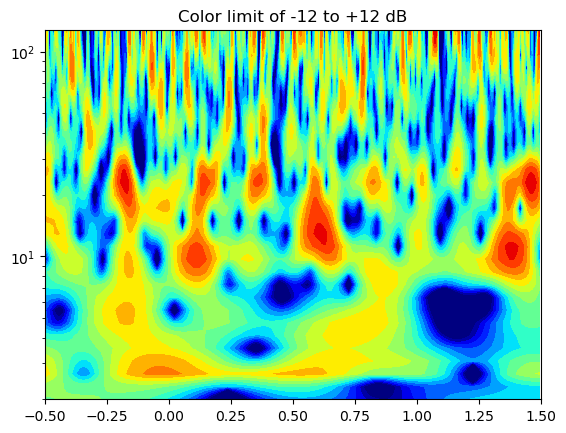

In [6]:
# define baseline period
baselinetime = np.array([-.5, -.2]) # in s

baselineidx =np.zeros(2,dtype=int)

# convert baseline window time to indices
baselineidx[0]=np.argmin(np.abs(times-baselinetime[0]))
baselineidx[1]=np.argmin(np.abs(times-baselinetime[1]))

#dB-correct
baseline_power = np.mean(tf_data[:,baselineidx[0]:baselineidx[1]],axis=1)
dbconverted = 10*np.log10(tf_data/np.reshape(baseline_power,[len(baseline_power),1]))

# FYI: the following lines of code are equivalent to the previous line:
#dbconverted = 10*(np.log10(tf_data)- np.reshape(np.log10(baseline_power),[len(baseline_power),1]))

plt.contourf(times,frequencies,dbconverted,40,vmin=-12,vmax=12,cmap='jet')
plt.setp(plt.gca(),'xlim', [-.5,1.5], 'yticks',np.round(np.logspace(np.log10(frequencies[0]),np.log10(frequencies[-1])*100)/100))
plt.yscale('log')
                          
_=plt.title('Color limit of -12 to +12 dB')

## Figure 18.4

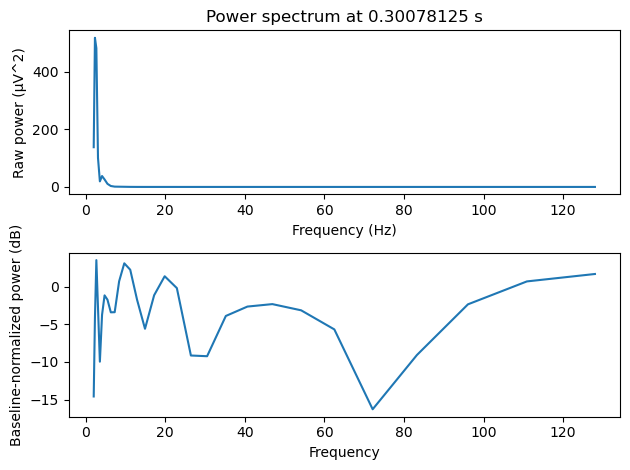

In [7]:
time2plot = .3 # in s

timeidx = np.argmin(np.abs(times-time2plot))

# plot frequencies
plt.subplot(2,1,1)
plt.plot(frequencies,tf_data[:,timeidx])
plt.setp(plt.gca(), 'xlabel', 'Frequency (Hz)', 'ylabel', 'Raw power (μV^2)', 'title', 'Power spectrum at ' + str(times[timeidx]) + ' s' )

plt.subplot(2,1,2)
plt.plot(frequencies,dbconverted[:,timeidx])
plt.setp(plt.gca(), 'xlabel', 'Frequency', 'ylabel', 'Baseline-normalized power (dB)')

plt.tight_layout()

## Figure 18.5

In [8]:
# This figure was created by changing the color limits of figure 18.3

## Figure 18.6

dB of -2 corresponds to -36.99999999999996% change.
dB of +2 corresponds to +58.000000000000135% change.


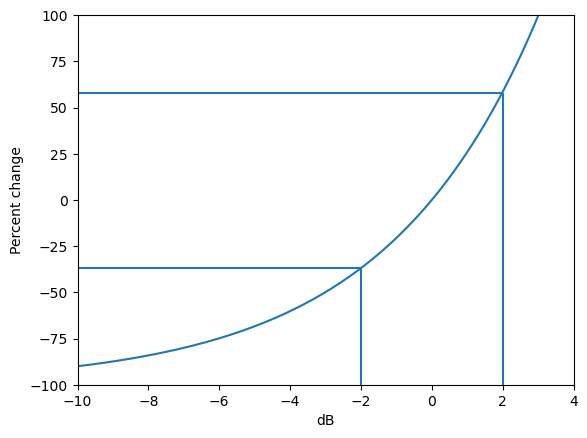

In [9]:
activity = np.arange(1,20+.1,.1) # activity
baseline = 10 # baseline

db = 10*np.log10(activity / baseline)
pc = 100*(activity-baseline)/ baseline

plt.plot(db,pc)
plt.setp(plt.gca(), 'xlim', [-10,4], 'ylim', [-100,100], 'xlabel', 'dB', 'ylabel','Percent change')

# find indices where db is closest to -/+2
dbOf2 = np.argmin(np.abs(db-2));
dbOfminus2 = np.argmin(np.abs(db--2))

print('dB of -2 corresponds to ' + str(pc[dbOfminus2]) + '% change.')
print('dB of +2 corresponds to +' + str(pc[dbOf2]) + '% change.')


plt.vlines(2,-100,pc[dbOf2])
plt.hlines(pc[dbOf2],-10,2)

plt.vlines(-2,-100,pc[dbOfminus2])
_=plt.hlines(pc[dbOfminus2],-10,-2)

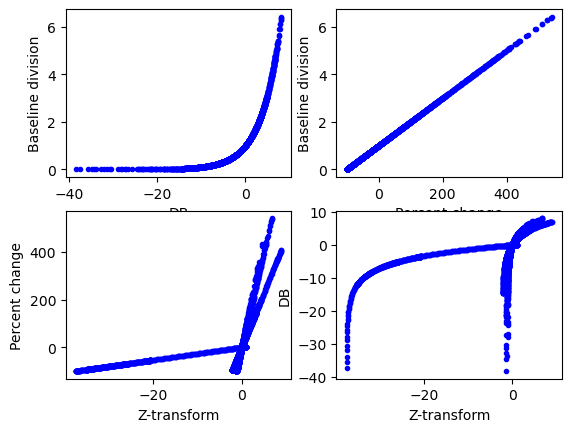

In [10]:
# real data: percent change vs. baseline division
baseline_power = np.mean(tf_data[:,baselineidx[0]:baselineidx[1]],axis=1)

pctchange = 100 * (tf_data - np.reshape(baseline_power,[len(baseline_power),1]))/np.reshape(baseline_power,[len(baseline_power),1])

plt.subplot(2,2,1)
baselinediv = tf_data / np.reshape(baseline_power,[len(baseline_power),1])
plt.plot(dbconverted[::5],baselinediv[::5],'.b') # don't need all the datapoints to make a point
plt.setp(plt.gca(), 'xlabel','DB', 'ylabel','Baseline division')

# dB vs. baseline division
plt.subplot(2,2,2)
plt.plot(pctchange[::5],baselinediv[::5],'.b')
plt.setp(plt.gca(),'xlabel','Percent change','ylabel','Baseline division')

# Z-transform vs. percent change
plt.subplot(2,2,3)
baseline_power = tf_data[:,baselineidx[0]:baselineidx[1]];
baselineZ = (tf_data - np.reshape(np.mean(baseline_power,axis=1),[len(baseline_power),1]))/np.reshape(np.std(baseline_power,axis=1),[len(baseline_power),1])

plt.plot(baselineZ[::5],pctchange[::5],'.b')
plt.setp(plt.gca(),'xlabel', 'Z-transform', 'ylabel','Percent change')

#Z-transform vs. dB
plt.subplot(2,2,4)
plt.plot(baselineZ[::5],dbconverted[::5],'.b')
_=plt.setp(plt.gca(),'xlabel', 'Z-transform', 'ylabel','DB')

## Figure 18.7

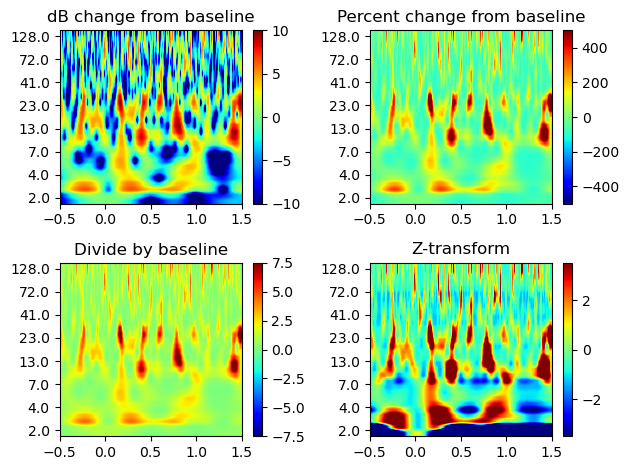

In [11]:
# plot dB-converted power
plt.subplot(2,2,1)
plt.imshow(dbconverted, aspect='auto',cmap='jet',vmin=-10,vmax=10, origin='lower', extent=[-.5,1.5,0,30])
plt.setp(plt.gca(),'yticks',ytickskip-1,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-.5, 1.5], 'title', 'dB change from baseline')
plt.colorbar()

# plot percent-change
plt.subplot(2,2,2)
plt.imshow(pctchange, aspect='auto',cmap='jet',vmin=-500,vmax=500, origin='lower', extent=[-.5,1.5,0,30])
plt.setp(plt.gca(),'yticks',ytickskip-1,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-.5, 1.5], 'title', 'Percent change from baseline')
plt.colorbar()

# divide by baseline
plt.subplot(2,2,3)
plt.imshow(baselinediv, aspect='auto',cmap='jet',vmin=-7.5,vmax=7.5, origin='lower', extent=[-.5,1.5,0,30])
plt.setp(plt.gca(),'yticks',ytickskip-1,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-.5, 1.5], 'title', 'Divide by baseline')
plt.colorbar()

# z-transform
plt.subplot(2,2,4)
plt.imshow(baselineZ, aspect='auto',cmap='jet',vmin=-3.5,vmax=3.5, origin='lower', extent=[-.5,1.5,0,30])
plt.setp(plt.gca(),'yticks',ytickskip-1,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-.5, 1.5], 'title', 'Z-transform')
plt.colorbar()

plt.tight_layout()

## Figure 18.8

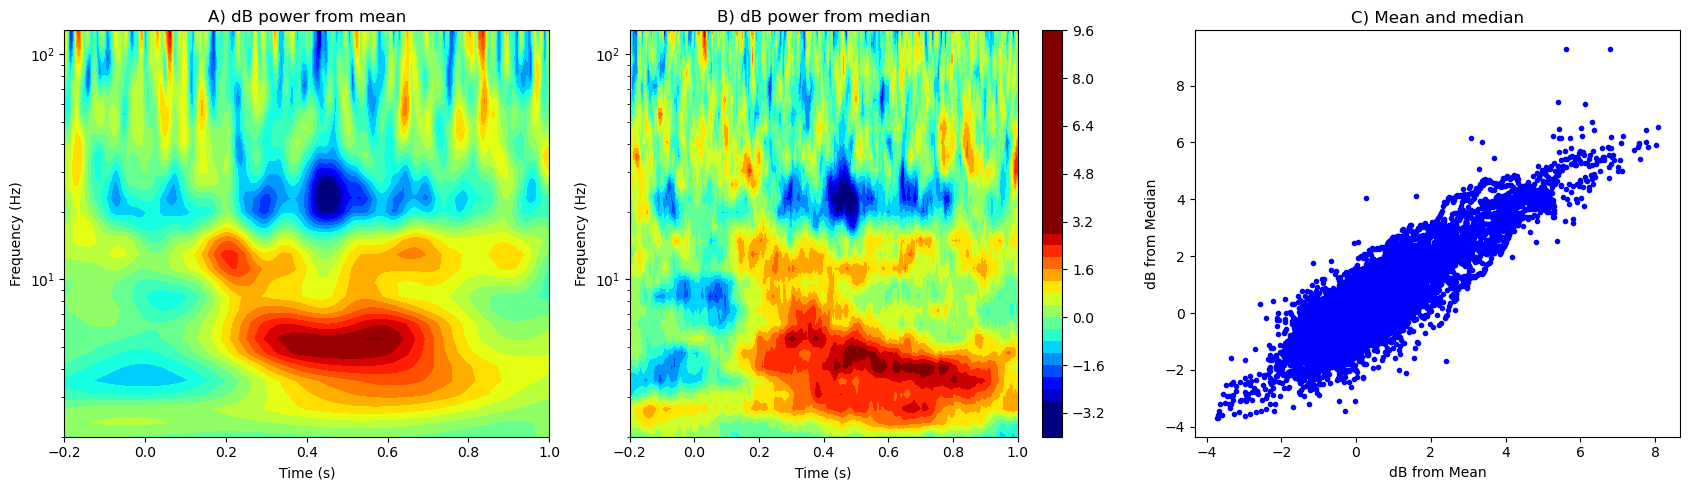

In [12]:
chan2plot = chan_labels.index('FCz') # p1 for figure 18.11
# define baseline period
baselinetime = np.array([-.5, -.2])# in s

# convert baseline window time to indices
baselineidx[0] = np.argmin(np.abs(times-baselinetime[0]))
baselineidx[1] = np.argmin(np.abs(times-baselinetime[1]))

tf_data = np.zeros([2,len(frequencies),pnts])

n_data        = pnts*trials;
n_convolution = n_wavelet+n_data-1;
n_conv_pow2   = int(2**np.ceil(np.log2(n_convolution)))

fft_data = np.fft.fft(np.reshape(data[:, chan2plot,:],[640*99]),n_conv_pow2)

for fi in range(len(frequencies)):
    
    #create wavelet and get its FFT
    wavelet = (np.pi*frequencies[fi]*np.sqrt(np.pi))**-.5 * np.exp(2*1j*np.pi*frequencies[fi]*time)* np.exp(-time**2/(2*( wavelet_cycles /(2*np.pi*frequencies[fi]))**2))/frequencies[fi]
    fft_wavelet = np.fft.fft(wavelet,n_conv_pow2)
    
    #run convolution
    convolution_result_fft = np.fft.ifft(fft_wavelet*fft_data,n_conv_pow2)
    convolution_result_fft = convolution_result_fft[:n_convolution]
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
    convolution_result_fft = np.reshape(convolution_result_fft,[pnts, trials],'F')
    
    if fi==6: # save single-trial data from one frequency band
        convdat2keep = convolution_result_fft
    
    
    # put power data into time-frequency matrix
    tf_data[0,fi,:] = np.mean(np.abs(convolution_result_fft)**2,axis=1)
    tf_data[1,fi,:] = np.median(np.abs(convolution_result_fft)**2,axis=1)

#db-correct and plot
labelz = ['mean','median']


plt.figure(figsize=(17,5))

baseline_power = np.mean(tf_data[0,:,baselineidx[0]:baselineidx[1]],axis=1)
dbconverted = 10*np.log10(tf_data[0,:,:]/np.reshape(baseline_power,[len(baseline_power),1]))

# plot
plt.subplot(1,3,1)
plt.contourf(times,frequencies,dbconverted,40,vmin=-3,vmax=3,cmap='jet')
plt.setp(plt.gca(),'xlim',[-.2, 1],'yticks',np.logspace(np.log10(frequencies[0]),np.log10(frequencies[-1]),6),
         'yticklabels',np.round(np.logspace(np.log10(frequencies[0]),np.log10(frequencies[-1]),6)*10)/10,
        'xlabel', 'Time (s)', 'ylabel', 'Frequency (Hz)', 'title', 'A) dB power from mean')
plt.yscale('log')

baseline_power = np.mean(tf_data[1,:,baselineidx[0]:baselineidx[1]],axis=1)
dbconverted = 10*np.log10(tf_data[1,:,:]/np.reshape(baseline_power,[len(baseline_power),1]))

plt.subplot(1,3,2)
plt.contourf(times,frequencies,dbconverted,40,vmin=-3,vmax=3,cmap='jet')
plt.setp(plt.gca(),'xlim',[-.2, 1],'yticks',np.logspace(np.log10(frequencies[0]),np.log10(frequencies[-1]),6),
         'yticklabels',np.round(np.logspace(np.log10(frequencies[0]),np.log10(frequencies[-1]),6)*10)/10,
        'xlabel', 'Time (s)', 'ylabel', 'Frequency (Hz)', 'title', 'B) dB power from median')
plt.yscale('log')
plt.colorbar()    

#plot relationship between mean and median
plt.subplot(1,3,3)
db_mean = 10*np.log10(tf_data[0,:,:]/np.reshape(np.mean(tf_data[0,:,baselineidx[0]:baselineidx[1]],axis=1),[30,1]))
db_medn = 10*np.log10(tf_data[1,:,:]/np.reshape(np.mean(tf_data[1,:,baselineidx[0]:baselineidx[1]],axis=1),[30,1]))

plt.plot(db_mean[:],db_medn[:],'.b')
r=np.corrcoef(np.ravel(db_mean[:]),np.ravel(db_medn[:]))[0,1]
plt.title('R^2 = ' +str(r*r) )
plt.setp(plt.gca(),'xlabel', 'dB from Mean', 'ylabel', 'dB from Median', 'title', 'C) Mean and median')

plt.tight_layout()

## Figure 18.9

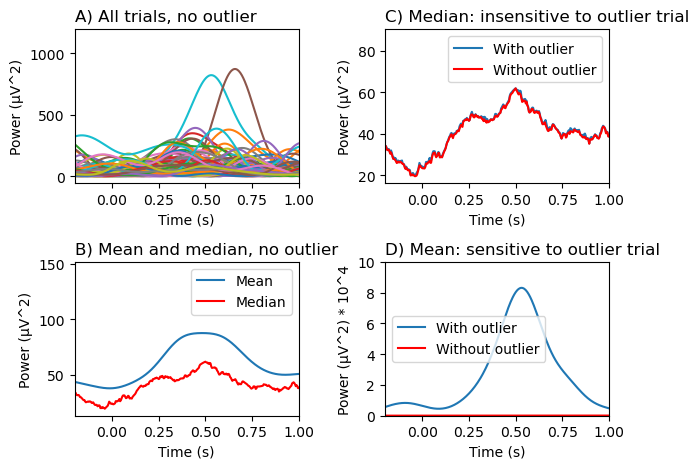

In [13]:
# to make this point even more clear, add an outlier trial
convdat2keep2 = convdat2keep.copy()
convdat2keep2[:,98] = convdat2keep[:,9]*100

# plot all trials, mean, and median
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(2,2,1)
plt.plot(times,np.abs(convdat2keep)**2)
plt.setp(plt.gca(),'xlim',[-.2, 1], 'xlabel', 'Time (s)', 'ylabel', 'Power (μV^2)')
plt.title('A) All trials, no outlier', loc='left')


plt.subplot(2,2,2)
plt.plot(times,np.median(np.abs(convdat2keep2)**2,axis=1))
plt.plot(times,np.median(np.abs(convdat2keep2[:,:-1])**2,axis=1),'r')
plt.setp(plt.gca(),'xlim',[-.2, 1], 'xlabel', 'Time (s)', 'ylabel', 'Power (μV^2)')
plt.legend(['With outlier','Without outlier'])
plt.title('C) Median: insensitive to outlier trial', loc='left')


plt.subplot(2,2,3)
plt.plot(times,np.mean(np.abs(convdat2keep)**2,axis=1))
plt.plot(times,np.median(np.abs(convdat2keep)**2,axis=1),'r')
plt.title('B) Mean and median, no outlier', loc='left')
plt.legend(['Mean', 'Median'])
_=plt.setp(plt.gca(),'xlim',[-.2, 1], 'xlabel', 'Time (s)', 'ylabel', 'Power (μV^2)')

plt.subplot(2,2,4)
plt.plot(times,np.mean(np.abs(convdat2keep2)**2/10000,axis=1))
plt.plot(times,np.mean(np.abs(convdat2keep2[:,:-1])**2/10000,axis=1),'r')
plt.setp(plt.gca(),'xlim',[-.2, 1], 'ylim', [0, 10], 'xlabel', 'Time (s)', 'ylabel', 'Power (μV^2) * 10^4')
plt.legend(['With outlier','Without outlier'])
plt.title('D) Mean: sensitive to outlier trial', loc='left')

plt.tight_layout()

## Figure 18.10

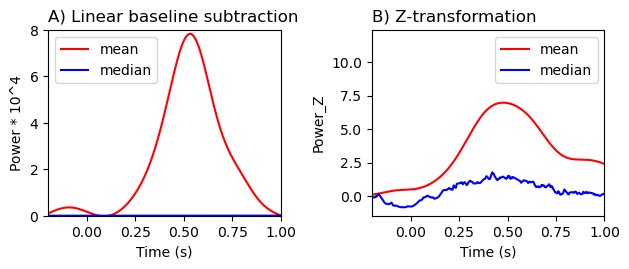

In [14]:
# convenientize power
convdatPower  = np.abs(convdat2keep2)**2;

# single-trial linear baseline correction
convdat2keepB = convdatPower - np.mean(convdatPower[baselineidx[0]:baselineidx[1],:],axis=0)

# single-trial Z score
convdat2keepZ = (convdatPower - np.mean(convdatPower[baselineidx[0]:baselineidx[1],:],axis=0)) / np.std(convdatPower[baselineidx[0]:baselineidx[1],:],axis=0)

# single-trial log10
convdat2keepL = np.log10(convdatPower)

plt.subplot(2,2,1)
plt.plot(times, np.mean(convdat2keepB,axis=1)/10000,'r')
plt.plot(times, np.median(convdat2keepB,axis=1)/10000,'b')
plt.setp(plt.gca(),'xlim',[-.2, 1], 'ylim', [0, 8], 'xlabel', 'Time (s)', 'ylabel', 'Power * 10^4')
plt.title('A) Linear baseline subtraction', loc='left')
plt.legend(['mean','median'])

plt.subplot(2,2,2)
plt.plot(times, np.mean(convdat2keepZ,axis=1),'r')
plt.plot(times, np.median(convdat2keepZ,axis=1),'b')
plt.setp(plt.gca(),'xlim',[-.2, 1], 'xlabel', 'Time (s)', 'ylabel', 'Power_Z')
plt.title('B) Z-transformation', loc='left')
plt.legend(['mean','median'])

_=plt.tight_layout()

## Figure 18.11

In [15]:
# This figure was made by running the code for figure 28.8 but using P1
# instead of FCz. (Fewer frequencies were also plotted.)

## Figure 18.12

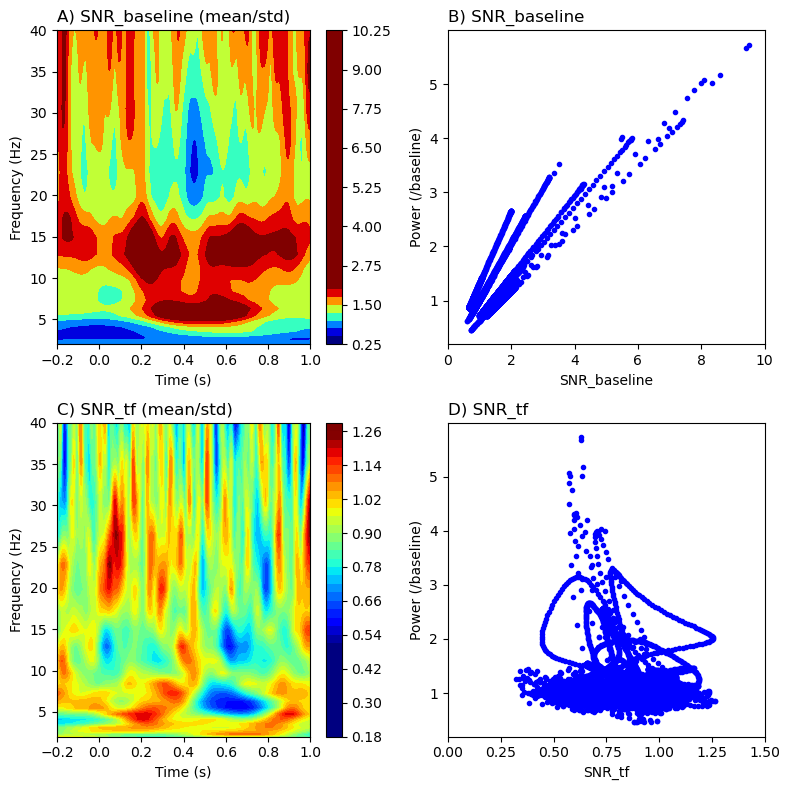

In [16]:
snr_bs = np.zeros([len(frequencies), pnts])
snr_tf = np.zeros([len(frequencies), pnts])
tf     = np.zeros([len(frequencies), pnts])

for fi in range(len(frequencies)):
    
    # create wavelet and get its FFT
    wavelet = (np.pi*frequencies[fi]*np.sqrt(np.pi))**-.5 * np.exp(2*1j*np.pi*frequencies[fi]*time)* np.exp(-time**2/(2*( wavelet_cycles /(2*np.pi*frequencies[fi]))**2))/frequencies[fi] 
    fft_wavelet = np.fft.fft(wavelet,n_conv_pow2)
    
    # run convolution
    convolution_result = np.fft.ifft(fft_wavelet*fft_data,n_conv_pow2) * np.sqrt(wavelet_cycles /(2*np.pi*frequencies[fi]))
    convolution_result = convolution_result[:n_convolution]
    convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
    convolution_result = np.reshape(convolution_result,[pnts,trials], 'F')
    
    # extract SNR in two ways
    snr_tf[fi,:] = np.mean(np.abs(convolution_result)**2,axis=1)/np.std(np.abs(convolution_result)**2,axis=1)
    snr_bs[fi,:] = np.mean(np.abs(convolution_result)**2,axis=1)/np.std(np.mean(np.abs(convolution_result[baselineidx[0]:baselineidx[1],:])**2,axis=0))

    tf[fi,:] = np.mean(np.abs(convolution_result)**2,axis=1)

# plot
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.contourf(times,frequencies,snr_bs,40,vmin=.5,vmax=2,cmap='jet')
plt.setp(plt.gca(),'xlim',[-.2, 1],'ylim',[frequencies[0], 40], 'xlabel', 'Time (s)', 'ylabel', 'Frequency (Hz)')
plt.title('A) SNR_baseline (mean/std)', loc='left')
plt.colorbar()

plt.subplot(2,2,2)
baseline_power = np.mean(tf[:,baselineidx[0]:baselineidx[1]],axis=1)
baselinediv    = tf / baseline_power[:,np.newaxis];
plt.plot(snr_bs[::3],baselinediv[::3],'b.')
plt.setp(plt.gca(), 'xlim', [0,10],'xlabel', 'SNR_baseline', 'ylabel', 'Power (/baseline)')
plt.title('B) SNR_baseline', loc='left')

plt.subplot(223)
plt.contourf(times,frequencies,snr_tf,40,vmin=.5,vmax=1.25,cmap='jet')
plt.setp(plt.gca(),'xlim',[-.2, 1],'ylim',[frequencies[0], 40], 'xlabel', 'Time (s)', 'ylabel', 'Frequency (Hz)')
plt.title('C) SNR_tf (mean/std)', loc='left')
plt.colorbar()

plt.subplot(224)
plt.plot(snr_tf[::3],baselinediv[::3],'b.')
plt.setp(plt.gca(), 'xlim', [0, 1.5],'xlabel', 'SNR_tf', 'ylabel', 'Power (/baseline)')
plt.title('D) SNR_tf', loc='left')

plt.tight_layout()

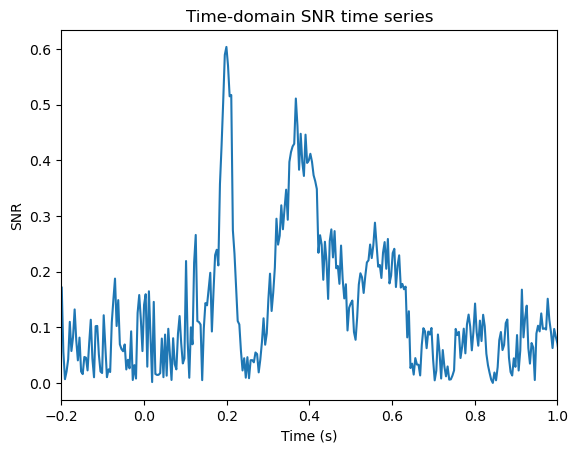

In [17]:
# time-series of SNR
plt.plot(times,np.abs(np.mean(data[:, 46,:],axis=0) / np.std(data[:, 46,:],axis=0)))
plt.title('Time-domain SNR time series')
_=plt.setp(plt.gca(),'xlim',[-.2, 1], 'xlabel', 'Time (s)', 'ylabel', 'SNR')

## Figure 18.13

In [18]:
def dsearchn(X, p):
    disp = X - p
    return np.argmin((disp*disp))


def fig1813(ch):
    fft_data = np.fft.fft(np.reshape(data[:, ch,:],[len(times)*trials] ,'F'),n_conv_pow2);
    timeidx = np.array([dsearchn(times,x) for x in [start_time,end_time]])
    powerByTrialFreq = np.zeros([len(frequencies),trials])

    for fi in range(len(frequencies)):

        # create wavelet and get its FFT
        wavelet = np.exp(2*1j*np.pi*frequencies[fi]*time) * np.exp(-time**2/(2*(wavelet_cycles /(2*np.pi*frequencies[fi]))**2))/frequencies[fi]
        fft_wavelet = np.fft.fft(wavelet,n_conv_pow2)

       # run convolution
        convolution_result = np.fft.ifft(fft_wavelet*fft_data,n_conv_pow2) * np.sqrt(wavelet_cycles /(2*np.pi*frequencies[fi]))
        convolution_result = convolution_result[:n_convolution]
        convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
        convolution_result = np.abs(np.reshape(convolution_result,[pnts,trials],'F'))**2 # reshape and convert to power

        # "gold standard" is average of all trials
        if dbcorrect:
            a = np.mean(convolution_result,axis=1)
            b = np.mean(np.mean(convolution_result[baselineidx[0]:baselineidx[1],:],axis=0),axis=1)
            template = 10*np.log10(a/b)
            template = template[timeidx[0]:timeidx[1]]
        else:
            template = np.mean(convolution_result[int(timeidx[0]):int(timeidx[1]),:],axis=1)

        # normalize template for correlation
        template = (template - np.mean(template)) / np.std(template)

        for iteri in range(iterations):
            for triali in np.arange(4,trials): # start at 5 trials...

                trials2use = np.random.choice(np.arange(trials),triali, replace=False)

                # compute power time series from the random selection of trials, and then normalization
                if dbcorrect:
                    a = np.mean(convolution_result[:,trials2use],axis=1)
                    b = np.mean(np.mean(convolution_result[baselineidx[0]:baselineidx[1],trials2use],axis=0),axis=1)
                    tempdat = 10*np.log10(a/b)
                    tempdat = tempdat[timeidx[0]:timeidx[1]]
                else:
                    tempdat = np.mean(convolution_result[timeidx[0]:timeidx[1],trials2use],axis=1)

                tempdat = (tempdat - np.mean(tempdat))/np.std(tempdat)
                # compute Pearson correlation. This is a super-fast
                #  implementation of a Pearson correlation via least squares
                # fit. You'll learn more about this in Chapter 28. 
                powerByTrialFreq[fi,triali] +=  np.linalg.solve((np.mat(tempdat) * np.mat(tempdat).T),(np.mat(tempdat)*np.mat(template).T))

    powerByTrialFreq /= iterations

    return powerByTrialFreq

In [19]:
iterations= 10;
chan2plot0 = chan_labels.index('FCz') 
chan2plot1 = chan_labels.index('P7')
dbcorrect = False


start_time = -.2 # in s
end_time   = 1.2

powerByTrialFreq0 = fig1813(chan2plot0)
powerByTrialFreq1 = fig1813(chan2plot1)

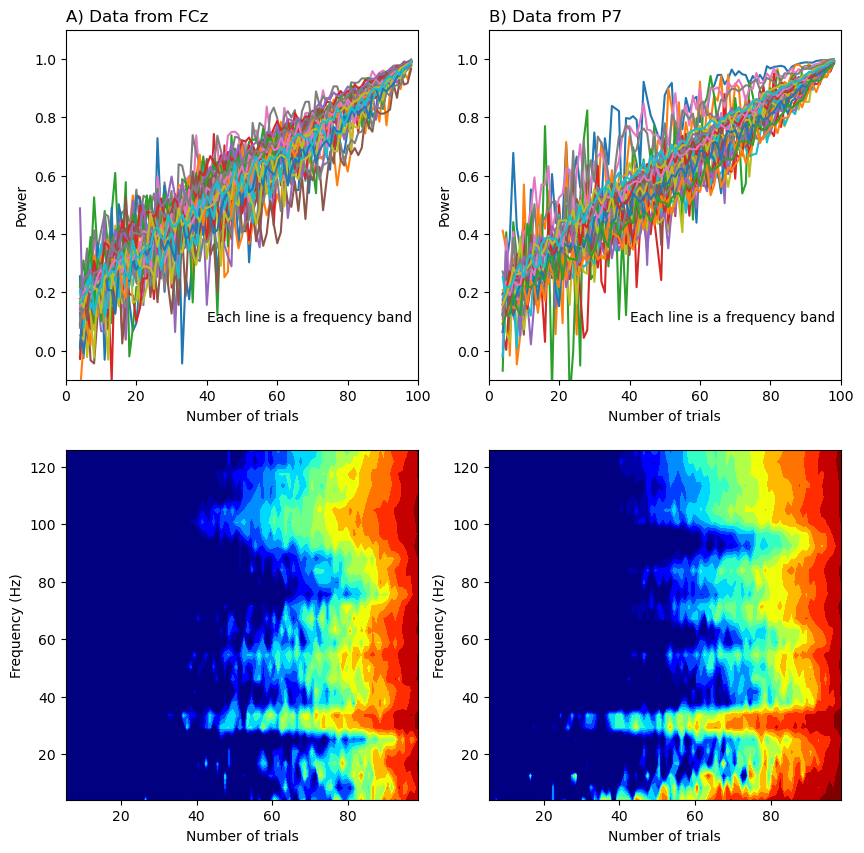

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(np.arange(4,trials),powerByTrialFreq0[:,4:].T)
plt.setp(plt.gca(), 'xlim', [0,100], 'ylim', [-.1,1.1], 'xlabel', 'Number of trials', 'ylabel', 'Power')
plt.title('A) Data from FCz', loc='left')
plt.text(40,0.1, 'Each line is a frequency band')

plt.subplot(2,2,2)
plt.plot(np.arange(4,trials),powerByTrialFreq1[:,4:].T)
plt.setp(plt.gca(), 'xlim', [0,100], 'ylim', [-.1,1.1], 'xlabel', 'Number of trials', 'ylabel', 'Power')
plt.title('B) Data from P7', loc='left')
plt.text(40,0.1, 'Each line is a frequency band')

plt.subplot(2,2,3)
plt.contourf(powerByTrialFreq0[:,5:],40,cmap='jet',origin="lower", vmin=.6, vmax=1, extent = [5,99,frequencies[0],frequencies[-1]])
plt.setp(plt.gca(), 'xlabel', 'Number of trials', 'ylabel','Frequency (Hz)')

plt.subplot(2,2,4)
plt.contourf(powerByTrialFreq1[:,5:],40,cmap='jet',origin="lower", vmin=.6, vmax=1, extent = [5,99,frequencies[0],frequencies[-1]])
_=plt.setp(plt.gca(), 'xlabel', 'Number of trials', 'ylabel','Frequency (Hz)')